# Yelp Review Sentiment Analysis

**Authors:** Anas Khalil, Mourad Mahmoudi  
**Task:** 5-class sentiment classification (1–5 stars)

**Dataset:** Yelp Review Full (Hugging Face)  
https://huggingface.co/datasets/Yelp/yelp_review_full

---

## Objective
Fine-tune a transformer model to perform sentiment analysis on Yelp restaurant reviews and outperform a provided BERT baseline.

## Approach
- Text cleaning and normalization
- Tokenization with a maximum length of 256 tokens
- Fine-tuning **DistilRoBERTa-base** for sequence classification

## Evaluation
- Training time
- Confusion matrix
- Precision, Recall, F1-score  
(Test split used strictly for final evaluation)

## Outputs
Trained model, checkpoints, classification report, and confusion matrix.


In [1]:
import os
os.makedirs("/mnt/yelp_sa/notebooks", exist_ok=True)
os.chdir("/mnt/yelp_sa")
print("Now in:", os.getcwd())

Now in: /mnt/yelp_sa


In [2]:
import os, time, re, math, random
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

In [3]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla V100-PCIE-16GB


In [4]:
ds = load_dataset("Yelp/yelp_review_full")
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [5]:
def text_len(ex):
    return {"n_chars": len(ex["text"]), "n_words": len(ex["text"].split())}

ds_len = ds.map(text_len, num_proc=2)
train_lens = ds_len["train"].select(range(20000))  # sample rapide EDA
lens = pd.DataFrame({
    "n_chars": train_lens["n_chars"],
    "n_words": train_lens["n_words"]
})
lens.describe()

,n_chars,n_words
count,20000.000000,20000.000000
mean,708.389300,129.089400
std,630.664043,114.738438
min,1.000000,1.000000
25%,282.000000,52.000000
50%,536.000000,98.000000
75%,929.000000,169.000000
max,5026.000000,954.000000


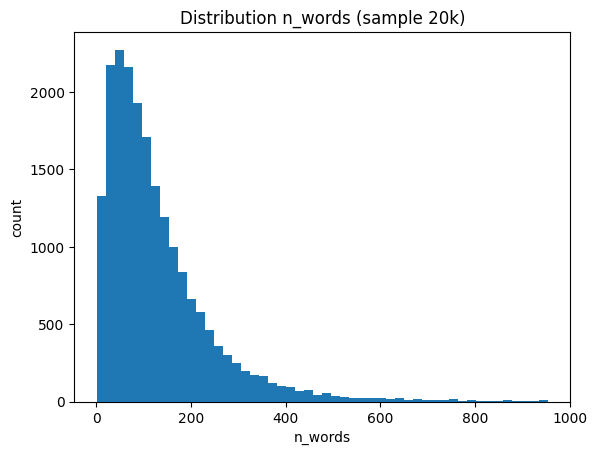

In [6]:
plt.figure()
plt.hist(lens["n_words"], bins=50)
plt.title("Distribution n_words (sample 20k)")
plt.xlabel("n_words")
plt.ylabel("count")
plt.show()

In [7]:
url_re = re.compile(r"http\S+|www\.\S+")
space_re = re.compile(r"\s+")

def clean_text(example):
    t = example["text"]
    t = url_re.sub(" ", t)
    t = t.replace("\n", " ")
    t = space_re.sub(" ", t).strip()
    return {"text": t}

ds_clean = ds.map(clean_text, num_proc=2)

In [8]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)

ds_tok = ds_clean.map(tokenize, batched=True, num_proc=2)
ds_tok = ds_tok.rename_column("label", "labels")
ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [9]:
seed = 42
train_size = 120_000
eval_size  = 20_000
test_size  = 20_000

train_ds = ds_tok["train"].shuffle(seed=seed).select(range(train_size))
eval_ds  = ds_tok["train"].shuffle(seed=seed+1).select(range(eval_size))
test_ds  = ds_tok["test"].shuffle(seed=seed).select(range(test_size))

len(train_ds), len(eval_ds), len(test_ds)

(120000, 20000, 20000)

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision_w": p, "recall_w": r, "f1_w": f1}

In [11]:
pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [12]:
import transformers
print(transformers.__version__)

5.0.0


In [13]:
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

args = TrainingArguments(
    output_dir="/mnt/yelp_sa/outputs/run1",
    save_strategy="no",
    load_best_model_at_end=False,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
)

Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: distilroberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [14]:
import os
print(os.getcwd())

/mnt/yelp_sa


In [15]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
import time

start_time = time.time()
trainer.train()
end_time = time.time()
train_time = end_time - start_time

Step,Training Loss,Validation Loss,Accuracy,Precision W,Recall W,F1 W
500,0.991303,0.935111,0.589500,0.588237,0.589500,0.582043
1000,0.929627,0.964652,0.577650,0.633079,0.577650,0.578370
1500,0.896473,0.864383,0.617850,0.617750,0.617850,0.616246
2000,0.874238,0.880638,0.614350,0.610400,0.614350,0.602010
2500,0.847853,0.851705,0.625950,0.619602,0.625950,0.617514
3000,0.838789,0.834837,0.637000,0.645169,0.637000,0.638675
3500,0.861027,0.810120,0.642350,0.655631,0.642350,0.646246
4000,0.852993,0.801704,0.651200,0.647888,0.651200,0.648529
4500,0.832133,0.813372,0.646450,0.658165,0.646450,0.648886
5000,0.822157,0.793682,0.652750,0.662591,0.652750,0.655814


In [16]:
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids
y_pred = logits.argmax(axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm

              precision    recall  f1-score   support

           0     0.7836    0.7619    0.7726      4049
           1     0.5947    0.6309    0.6123      3950
           2     0.6201    0.5566    0.5867      3983
           3     0.5795    0.6149    0.5967      4038
           4     0.7436    0.7497    0.7467      3980

    accuracy                         0.6631     20000
   macro avg     0.6643    0.6628    0.6630     20000
weighted avg     0.6646    0.6631    0.6632     20000



array([[3085,  840,   81,   19,   24],
       [ 711, 2492,  664,   61,   22],
       [  86,  793, 2217,  826,   61],
       [  23,   48,  562, 2483,  922],
       [  32,   17,   51,  896, 2984]])

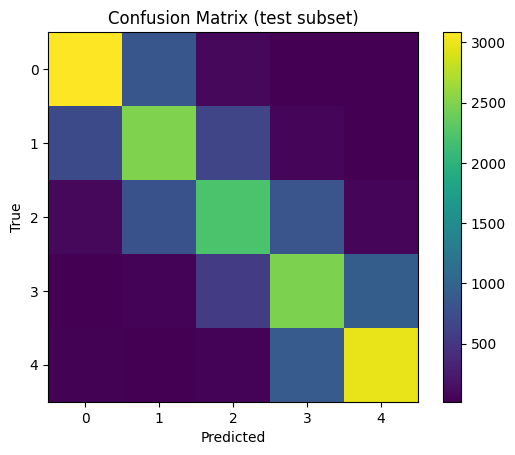

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (test subset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.savefig("/mnt/yelp_sa/figures/confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

In [18]:
trainer.save_model("/mnt/yelp_sa/models/distilroberta_yelp_run1")
tokenizer.save_pretrained("/mnt/yelp_sa/models/distilroberta_yelp_run1")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/mnt/yelp_sa/models/distilroberta_yelp_run1/tokenizer_config.json',
 '/mnt/yelp_sa/models/distilroberta_yelp_run1/tokenizer.json')

In [19]:
print(f"Training time (seconds): {train_time:.2f}")
print(f"Training time (minutes): {train_time/60:.2f}")

Training time (seconds): 601.68
Training time (minutes): 10.03


In [20]:
with open("/mnt/yelp_sa/docs/training_time.txt", "w") as f:
    f.write(f"Training time (seconds): {train_time:.2f}\n")
    f.write(f"Training time (minutes): {train_time/60:.2f}\n")

In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, digits=4)
print(report)

with open("/mnt/yelp_sa/docs/classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0     0.7836    0.7619    0.7726      4049
           1     0.5947    0.6309    0.6123      3950
           2     0.6201    0.5566    0.5867      3983
           3     0.5795    0.6149    0.5967      4038
           4     0.7436    0.7497    0.7467      3980

    accuracy                         0.6631     20000
   macro avg     0.6643    0.6628    0.6630     20000
weighted avg     0.6646    0.6631    0.6632     20000



In [22]:
import os
os.makedirs("/mnt/yelp_sa/notebooks", exist_ok=True)